In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import signal

In [ ]:
pickles_address = '/content/drive/MyDrive/Brain-Computer Interfaces/Epilepsy Dataset/Pickles/'
A_address = '/content/drive/MyDrive/Brain-Computer Interfaces/Epilepsy Dataset/Z/'
B_address = '/content/drive/MyDrive/Brain-Computer Interfaces/Epilepsy Dataset/O/'
C_address = '/content/drive/MyDrive/Brain-Computer Interfaces/Epilepsy Dataset/N/'
D_address = '/content/drive/MyDrive/Brain-Computer Interfaces/Epilepsy Dataset/F/'
E_address = '/content/drive/MyDrive/Brain-Computer Interfaces/Epilepsy Dataset/S/'

In [ ]:
with open(pickles_address + 'As.pickle', 'rb') as f:
    As = pickle.load(f)
with open(pickles_address + 'Bs.pickle', 'rb') as f:
    Bs = pickle.load(f)
with open(pickles_address + 'Cs.pickle', 'rb') as f:
    Cs = pickle.load(f)
with open(pickles_address + 'Ds.pickle', 'rb') as f:
    Ds = pickle.load(f)
with open(pickles_address + 'Es.pickle', 'rb') as f:
    Es = pickle.load(f)
print('As', As.shape)
print('Bs', Bs.shape)
print('Cs', Cs.shape)
print('Ds', Ds.shape)
print('Es', Es.shape)

As (4097, 100)
Bs (4097, 100)
Cs (4097, 100)
Ds (4097, 100)
Es (4097, 100)


[0.00000000e+00 4.24059599e-02 8.48119199e-02 ... 8.67201881e+01
 8.67625940e+01 8.68050000e+01]


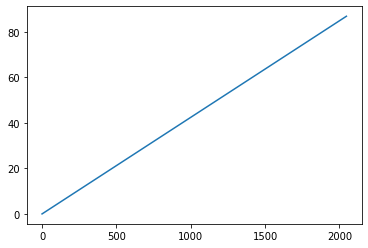

In [ ]:
n = len(As[:, 0])
fs = 173.61
rf = np.linspace(0, fs/2, num=round(n/2))
print(rf)
plt.plot(rf)
plt.show()

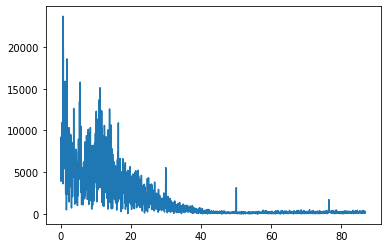

In [ ]:
sig = As[:, 0]
fx = np.fft.fft(sig)
fx = fx[:round(n/2)]                        # select half of all coeficients 
fx = np.absolute(fx)                        # caculate magnitudes

plt.plot(rf[1:], fx[1:])
plt.show()

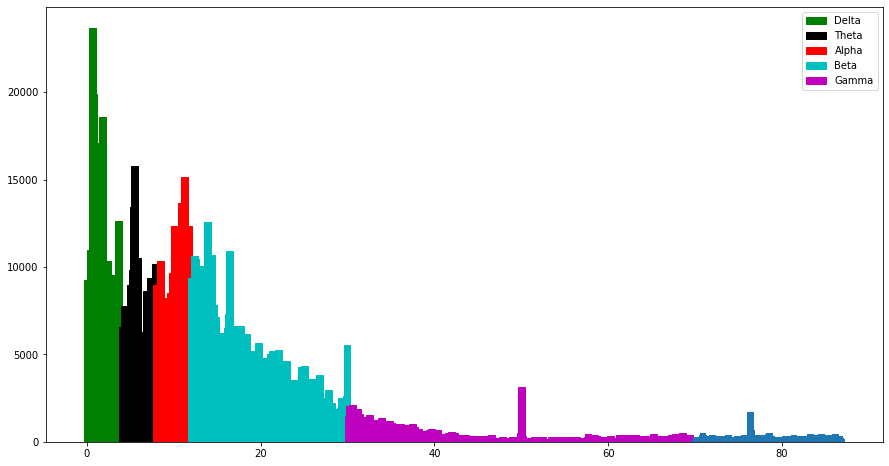

In [ ]:
import matplotlib.patches as mpatches

delta_idx = [i for i in range(len(rf)) if rf[i] > 0 and rf[i] <= 4]
theta_idx = [i for i in range(len(rf)) if rf[i] > 4 and rf[i] <= 8]
alpha_idx = [i for i in range(len(rf)) if rf[i] > 8 and rf[i] <= 12]
beta_idx = [i for i in range(len(rf)) if rf[i] > 12 and rf[i] <= 30]
gamma_idx = [i for i in range(len(rf)) if rf[i] > 30 and rf[i] <= 70]

plt.figure(figsize=(15,8))
barlist = plt.bar(rf[1:], fx[1:])
for i in delta_idx[1:]:
    barlist[i].set_color('g')
for i in theta_idx:
    barlist[i].set_color('k')
for i in alpha_idx:
    barlist[i].set_color('r')
for i in beta_idx:
    barlist[i].set_color('c')
for i in gamma_idx:
    barlist[i].set_color('m')
g_patch = mpatches.Patch(color='g', label='Delta')
k_patch = mpatches.Patch(color='k', label='Theta')
r_patch = mpatches.Patch(color='r', label='Alpha')
c_patch = mpatches.Patch(color='c', label='Beta')
m_patch = mpatches.Patch(color='m', label='Gamma')
plt.legend(handles=[g_patch, k_patch, r_patch, c_patch, m_patch])
plt.show()

In [ ]:
from statistics import mean
from scipy.stats import skew, kurtosis, entropy

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    y = signal.filtfilt(b, a, data)
    return y

In [ ]:
fs = 173.61
def feature_extractor(inp):
    inp_features = []
    for i in range(inp.shape[1]):
        trial = butter_bandstop_filter(inp[:, i], 49, 51, 173.61, 3)

        n = len(trial)
        fs = 173.61
        rf = np.linspace(0, fs/2, num=round(n/2))
        trial_fx = np.fft.fft(trial)
        trial_fx = trial_fx[:round(n/2)]                        # select half of all coeficients 
        trial_fx = np.absolute(trial_fx)                        # caculate magnitudes (we extract frequency features from magnitudes)

        m = mean(trial_fx)
        v = np.var(trial_fx)
        s = skew(trial_fx)
        k = kurtosis(trial_fx)
        e = entropy(trial_fx)
        p = mean(trial_fx ** 2)
        inp_features.append([m, v, s, k, e, p])

    return np.array(inp_features).T

As_features = feature_extractor(As)
Bs_features = feature_extractor(Bs)
Cs_features = feature_extractor(Cs)
Ds_features = feature_extractor(Ds)
Es_features = feature_extractor(Es)

As_features.shape, Bs_features.shape, Cs_features.shape, Ds_features.shape, Es_features.shape

((6, 100), (6, 100), (6, 100), (6, 100), (6, 100))

In [ ]:
def rhyme_based_feature_extractor(inp):
    inp_features = []
    for i in range(inp.shape[1]):
        trial = butter_bandstop_filter(inp[:, i], 49, 51, 173.61, 3)
        
        n = len(trial)
        fs = 173.61
        rf = np.linspace(0, fs/2, num=round(n/2))
        trial_fx = np.fft.fft(trial)
        trial_fx = trial_fx[:round(n/2)]                        # select half of all coeficients 
        trial_fx = np.absolute(trial_fx)                        # caculate magnitudes (we extract frequency features from magnitudes)

        delta_idx = [i for i in range(len(rf)) if rf[i] > 0 and rf[i] <= 4]
        theta_idx = [i for i in range(len(rf)) if rf[i] > 4 and rf[i] <= 8]
        alpha_idx = [i for i in range(len(rf)) if rf[i] > 8 and rf[i] <= 12]
        beta_idx = [i for i in range(len(rf)) if rf[i] > 12 and rf[i] <= 30]
        gamma_idx = [i for i in range(len(rf)) if rf[i] > 30 and rf[i] <= 70]

        trial_fx_delta = [trial_fx[i] for i in delta_idx]
        trial_fx_theta = [trial_fx[i] for i in theta_idx]
        trial_fx_alpha = [trial_fx[i] for i in alpha_idx]
        trial_fx_beta = [trial_fx[i] for i in beta_idx]
        trial_fx_gamma = [trial_fx[i] for i in gamma_idx]
        trial_fx_rhymes = [trial_fx_delta, trial_fx_theta, trial_fx_alpha, trial_fx_beta, trial_fx_gamma]

        rhymes_features = []
        for each_rhyme in trial_fx_rhymes:
            m = mean(each_rhyme)
            v = np.var(each_rhyme)
            s = skew(each_rhyme)
            k = kurtosis(each_rhyme)
            e = entropy(each_rhyme)
            p = mean(list(np.array(each_rhyme) ** 2))
            rhymes_features.append([m, v, s, k, e, p])
        inp_features.append(np.array(rhymes_features).reshape(30, 1))
    return np.array(inp_features).T[0]


As_rhyme_features = rhyme_based_feature_extractor(As)
Bs_rhyme_features = rhyme_based_feature_extractor(Bs)
Cs_rhyme_features = rhyme_based_feature_extractor(Cs)
Ds_rhyme_features = rhyme_based_feature_extractor(Ds)
Es_rhyme_features = rhyme_based_feature_extractor(Es)

As_rhyme_features.shape, Bs_rhyme_features.shape, Cs_rhyme_features.shape, Ds_rhyme_features.shape, Es_rhyme_features.shape

((30, 100), (30, 100), (30, 100), (30, 100), (30, 100))

In [ ]:
with open(pickles_address + 'As_features_F.pickle', 'wb') as f:
    pickle.dump(As_features, f)
with open(pickles_address + 'Bs_features_F.pickle', 'wb') as f:
    pickle.dump(Bs_features, f)
with open(pickles_address + 'Cs_features_F.pickle', 'wb') as f:
    pickle.dump(Cs_features, f)
with open(pickles_address + 'Ds_features_F.pickle', 'wb') as f:
    pickle.dump(Ds_features, f)
with open(pickles_address + 'Es_features_F.pickle', 'wb') as f:
    pickle.dump(Es_features, f)
with open(pickles_address + 'As_rhyme_features_F.pickle', 'wb') as f:
    pickle.dump(As_rhyme_features, f)
with open(pickles_address + 'Bs_rhyme_features_F.pickle', 'wb') as f:
    pickle.dump(Bs_rhyme_features, f)
with open(pickles_address + 'Cs_rhyme_features_F.pickle', 'wb') as f:
    pickle.dump(Cs_rhyme_features, f)
with open(pickles_address + 'Ds_rhyme_features_F.pickle', 'wb') as f:
    pickle.dump(Ds_rhyme_features, f)
with open(pickles_address + 'Es_rhyme_features_F.pickle', 'wb') as f:
    pickle.dump(Es_rhyme_features, f)